In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import os
import math

from torch import nn, optim
from torch.utils.data import TensorDataset, DataLoader, ConcatDataset
from matplotlib.lines import Line2D
from collections import Counter
from datetime import datetime
from utils import train, compute_accuracy

seed = 265
torch.manual_seed(seed)

device = (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))
print(f"Training on device {device}.")

Training on device cpu.


In [2]:
# ----------------------- Load Vocab, Embedding and Texts ----------------------------
PATH_GENERATED = './generated/'

vocab = torch.load(PATH_GENERATED + 'vocabulary.pt', map_location=torch.device(device))
embedding = torch.load(PATH_GENERATED + 'embedding.pt', map_location=torch.device(device))
(VOCAB_SIZE, embedding_dim) = embedding.weight.shape  

words_train = torch.load(PATH_GENERATED + "words_train.pt", map_location=torch.device(device))
words_val   = torch.load(PATH_GENERATED + "words_val.pt", map_location=torch.device(device))
words_test  = torch.load(PATH_GENERATED + "words_test.pt", map_location=torch.device(device))

In [3]:
# ---------------- Datasets -----------------------
CONTEXT_SIZE = 10
conjugation_list = ['be', 'am', 'are', 'is', 'was', 'were', 'been', 'being', 'have', 'has', 'had', 'having']
MAP_TARGET = {vocab[w]:i for i, w in enumerate(conjugation_list)}

def create_dataset(text, vocab, context_size=CONTEXT_SIZE, map_target=MAP_TARGET):
    """
    Create context-target pairs where the targets are all conjugations of the verbs "to be" and "to have".
    """
    # Transform each word to its index in the vocabulary.
    txt = [vocab[w] for w in text]

    n_text = len(text)
    context_center = int(context_size/2)

    contexts = []
    targets = []
    for i in range(n_text - context_size):
        
        t = txt[i + context_center]
        if  not vocab.lookup_token(t) in conjugation_list: continue # We only want to guess conjunctions of be and have.
        c = txt[i:i + context_center] + txt[i + context_center +1:i + context_size+1]
        
        targets.append(map_target[t]) 
        contexts.append(torch.tensor(c).to(device=device))
            
    contexts = torch.stack(contexts)
    targets = torch.tensor(targets).to(device=device)
    return TensorDataset(contexts, targets)

def load_dataset(words, vocab, fname):
    """
    Load dataset if already generated, otherwise, create it and save it
    """
    
    if os.path.isfile(PATH_GENERATED + fname):
        dataset = torch.load(PATH_GENERATED + fname, map_location=torch.device(device))
    else:
        dataset = create_dataset(words, vocab)
        torch.save(dataset, PATH_GENERATED + fname)
    return dataset

data_train_conj = load_dataset(words_train, vocab, "conj_data_train.pt")
data_val_conj   = load_dataset(words_val, vocab, "conj_data_val.pt")
data_test_conj  = load_dataset(words_test, vocab, "conj_data_test.pt")

# ---------------- Positional Encoding -----------------------
pos_encoding = torch.zeros((CONTEXT_SIZE, embedding_dim))
for i in range(CONTEXT_SIZE):
    for ii in range(int(embedding_dim/2)):
        pos_encoding[i][2*ii] = math.sin(i/1000**((2*ii)/embedding_dim))
        pos_encoding[i][2*ii +1] = math.cos(i/1000**((2*ii)/embedding_dim))

The distribution of the target words are very skewed, we need to weigh the words by their frequency in the training set

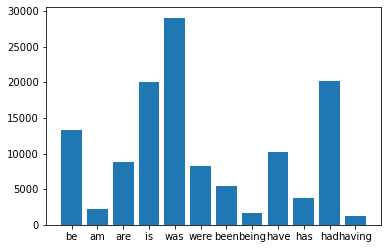

The frequency of the targets is skewed, we should weight the targets to balance the dataset.


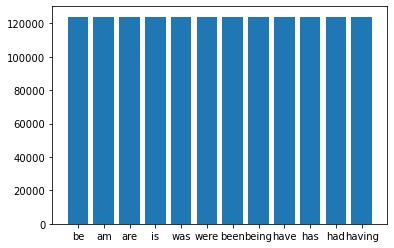

Post balance


In [4]:
def calculate_word_weights(values):
    """
    Calculate the weight of each word so that the loss function can weigh 
    frequent words less and unfrequent words more.
    """
    total_words = sum(values)
    word_weights = [total_words / value for value in values]
    word_weights = torch.tensor(word_weights, dtype=torch.float).to(device=device)
    return word_weights

counts = Counter(data_train_conj[:][1].tolist())
values = [int(counts[i]) for i in range(len(counts))]
plt.bar(conjugation_list, values)
plt.show()
print('The frequency of the targets is skewed, we should weight the targets to balance the dataset.')

word_weigts = calculate_word_weights(values)
values_balanced = [int(values[i])*w for i, w in enumerate(word_weigts)]
plt.bar(conjugation_list, values_balanced)
plt.show()
print('Post balance')

In [5]:
# ---------------- Simple MLP hyper parameters -----------------------
lrs = [0.1, 0.01, 0.001]
decays = [0.8, 0.5, 0.1]
mlp_hparams = [{
    'lr': lr,
    'weight_decay': decay
} for lr in lrs for decay in decays]

# ---------------- Attention MLP hyper parameters ----------------------- 
lrs = [0.1, 0.01, 0.001]
attention_hparams = [{
    'lr': lr,
} for lr in lrs]

# ---------------- RNN MLP hyper parameters ----------------------- 
lrs = [0.1, 0.01, 0.001]
rnn_hparams = [{
    'lr': lr,
} for lr in lrs]


train_loader = DataLoader(data_test_conj, batch_size=128, shuffle=True)
val_loader = DataLoader(data_val_conj, batch_size=128, shuffle=True)
test_loader = DataLoader(data_test_conj, batch_size=128, shuffle=True)

train_val_loader = DataLoader(ConcatDataset([data_train_conj, data_val_conj]), batch_size=128, shuffle=True)

In [6]:
# ---------------- MLP, Attention, and RNN models -----------------------
class SimpleMLP(nn.Module):
    def __init__(self, embedding, context_size=CONTEXT_SIZE):
        super().__init__()

        (vocab_size, embedding_dim) = embedding.weight.shape
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.embedding.load_state_dict(embedding.state_dict())
        for p in self.embedding.parameters():
            p.requires_grad = False

        self.fc1 = nn.Linear(embedding_dim*context_size, 256)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, 12)

    def forward(self, x):
        out = self.embedding(x)
        out = F.relu(self.fc1(torch.flatten(out, 1)))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)

        return out

class AttentionMLP(nn.Module):
    def __init__(self, embedding, n_heads=5):
        super().__init__()

        (vocab_size, embedding_dim) = embedding.weight.shape
        self.n_heads = n_heads
        self.embedding = nn.Embedding(VOCAB_SIZE, embedding_dim)
        self.embedding.load_state_dict(embedding.state_dict())
        for p in self.embedding.parameters():
            p.requires_grad = False

        self.W_q = nn.Parameter(torch.rand((self.n_heads, CONTEXT_SIZE, embedding_dim)))
        self.W_k = nn.Parameter(torch.rand((self.n_heads, CONTEXT_SIZE, embedding_dim)))
        self.W_v = nn.Parameter(torch.rand((self.n_heads, CONTEXT_SIZE, embedding_dim)))
        self.W_o = nn.Parameter(torch.rand((embedding_dim, self.n_heads * CONTEXT_SIZE)))

        self.fc1 = nn.Linear(embedding_dim*CONTEXT_SIZE, 256)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, 12)
    
    def forward(self, x):
        batch_size, _ = x.size()
        x = self.embedding(x)
        x = x + pos_encoding
        
        multi_attn_heads = []
        for ii in range(CONTEXT_SIZE):
            attn_heads = torch.empty(0)
            for i in range(self.n_heads):
                q = x[:,ii,:] @ self.W_q[i].T
                k = x[:,ii,:] @ self.W_k[i].T 
                v = x[:,ii,:] @ self.W_v[i].T
                
                attn_weights = torch.stack([q[j] @ k[j].T for j in range(batch_size)])
                attn_weights = torch.softmax(attn_weights / math.sqrt(CONTEXT_SIZE), dim=-1)
                attn_head = torch.unsqueeze(attn_weights, dim=1) * v
                attn_heads = torch.cat((attn_heads, attn_head), 1)
            multi_attn_heads.append(self.W_o @ attn_heads.T)
       
        multi_attn_heads = torch.stack(multi_attn_heads)
        out = multi_attn_heads.permute(2, 0, 1)
        out = F.relu(self.fc1(torch.flatten(out, 1)))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out
    
class RNN(nn.Module):
    def __init__(self, embedding):
        super().__init__()

        self.embedding = nn.Embedding(VOCAB_SIZE, embedding_dim)
        self.embedding.load_state_dict(embedding.state_dict())
        for p in self.embedding.parameters():
            p.requires_grad = False

        self.lstm = nn.LSTM(input_size=embedding_dim, hidden_size=12, batch_first=True, bidirectional=True)

    def forward(self, x):
        x = self.embedding(x)
        out, (h_n, c_n) = self.lstm(x)
        return h_n[-1]

In [7]:
def train_all_models():
    """
    Training MLP, MLP with attention, and RNN with given hyper-parameters
    """
    
    train_losses = []
    models = []
    accuracies = []
    params = []

    print("Now training a simple MLP model")
    for param in mlp_hparams:
        print(f"Training using parameters: {param}")
        torch.manual_seed(seed)
        model = SimpleMLP(embedding)
        loss_fn = nn.CrossEntropyLoss(weight=word_weigts)
        optimizer = optim.Adam(model.parameters(), **param)
        n_epochs = 10
        
        loss = train(n_epochs, optimizer, model, loss_fn, train_loader, device)
        accuracy = compute_accuracy(model, val_loader, device)

        models.append(model)
        train_losses.append(loss)
        accuracies.append(accuracy)
        params.append(param)
        print()

    print("Now training a MLP model with attention")
    for param in attention_hparams:
        print(f"Training using parameters: {param}")
        torch.manual_seed(seed)
        model = AttentionMLP(embedding)
        loss_fn = nn.CrossEntropyLoss(weight=word_weigts)
        optimizer = optim.Adam(model.parameters(), **param)
        n_epochs = 10
        
        loss = train(n_epochs, optimizer, model, loss_fn, train_loader, device)
        accuracy = compute_accuracy(model, val_loader, device)

        models.append(model)
        train_losses.append(loss)
        accuracies.append(accuracy)
        params.append(param)
        print()
    
    print("Now training a RNN model")
    for param in rnn_hparams:
        print(f"Training using parameters: {param}")
        torch.manual_seed(seed)
        model = RNN(embedding)
        loss_fn = nn.CrossEntropyLoss(weight=word_weigts)
        optimizer = optim.Adam(model.parameters(), **param)
        n_epochs = 10
        
        loss = train(n_epochs, optimizer, model, loss_fn, train_loader, device)
        accuracy = compute_accuracy(model, val_loader, device)

        models.append(model)
        train_losses.append(loss)
        accuracies.append(accuracy)
        params.append(param)
        print()
        
    return models, params, train_losses, accuracies

def select_best_model(models, params, accuracies):
    """
    Selecting the best performing model based on accuracy on the validation set,
    then re-training the model on the combined train+val set for more epochs.
    """
    best_idx = accuracies.index(max(accuracies))
    best_model = models[best_idx]
    best_param = params[best_idx]
    print(f"The best performing model is {best_model} with an accuracy of {accuracies[best_idx]}\n")
    
    print(f"Retraining best model for longer on train + val dataset")
    loss_fn = nn.CrossEntropyLoss(weight=word_weigts)
    torch.manual_seed(seed)
    optimizer = optim.Adam(best_model.parameters(), **best_param)
    n_epochs = 30

    torch.manual_seed(seed)
    best_model_loss = train(n_epochs, optimizer, best_model, loss_fn, train_val_loader, device)
    accuracy = compute_accuracy(best_model, test_loader, device)

    return best_model, best_model_loss, accuracy

In [8]:
# ----------------------- Best Model -------------------------------
if os.path.isfile(PATH_GENERATED + 'best_model_conjugation.pt'):
    best_model = torch.load(PATH_GENERATED + 'best_model_conjugation.pt')
    accuracy = torch.load(PATH_GENERATED + 'best_model_conjugation_accuracy.pt')
    train_losses = torch.load(PATH_GENERATED + 'best_model_conjugation_train_losses.pt')
    best_model_loss = torch.load(PATH_GENERATED + 'best_model_conjugation_best_loss.pt')
else:
    models, params, train_losses, val_accs = train_all_models()
    best_model, best_model_loss, accuracy = select_best_model(models, params, val_accs)
    torch.save(best_model, PATH_GENERATED + 'best_model_conjugation.pt')
    torch.save(accuracy, PATH_GENERATED + 'best_model_conjugation_accuracy.pt')
    torch.save(train_losses, PATH_GENERATED + 'best_model_conjugation_train_losses.pt')
    torch.save(best_model_loss, PATH_GENERATED + 'best_model_conjugation_best_loss.pt')

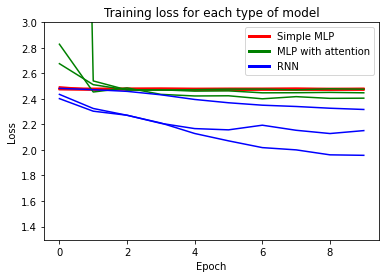

Training the best model more..


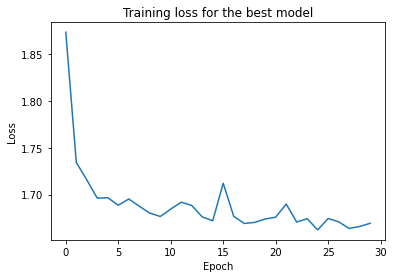

The accuracy of the best model on the test set was 0.35


In [9]:
# ----------------------- Plots -------------------------------
for i, loss in enumerate(train_losses):
    if i < 9:
        plt.plot(loss, "r-", label="Simple MLP")
    elif i < 12:
        plt.plot(loss, "g-", label="MLP with attention")
    else:
        plt.plot(loss, "b-", label="RNN")

colors = ['r', 'g', 'b']
lines = [Line2D([0], [0], color=c, linewidth=3, linestyle='-') for c in colors]
labels = ["Simple MLP", "MLP with attention", "RNN"]
plt.legend(lines, labels)
plt.ylim(top=3)
plt.title("Training loss for each type of model")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.show()

print("Training the best model more..")
plt.plot(best_model_loss)
plt.title("Training loss for the best model")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.show()
print(f"The accuracy of the best model on the test set was {round(accuracy, 2)}")